### LD Prune UKBB Estimates

This script will estimate how long it would take to LD prune a ~90G UKBB dataset.

The dataset assumed is ~812k variants x ~489k samples (see [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-018-0579-z/MediaObjects/41586_2018_579_MOESM1_ESM.pdf)):
> Genotype calling by Affymetrix resulted in a dataset of 489,212 individuals typed at 812,428 markers with which to carry out further QC

**Conclusion**: It takes ~66 mins to prune a worst-case region of the genome that is approximately 5% of the whole thing (on 16 logical core, 8 physical).  This implies that an upper bound on the time it would take is ~22 hrs for this machine and ~352 hours for a single core.

In [1]:
from lib import api
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import dask
%run ../nb/paths.py

In [2]:
target_shape = (812428, 489212)
target_shape

(812428, 489212)

In [3]:
path = PLINK_1KG_PATH_02
path

PosixPath('/lab/data/gwas/tutorial/2_PS_GWAS/1kG_MDS5')

Read 1KG data and downsample variants to unimputed density:

In [4]:
%%time
ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')[['data', 'contig', 'pos']]
ds = ds.sel(variant=ds.variant.isin(ds.variant.to_series().sample(n=target_shape[0], random_state=1)))
ds

CPU times: user 37.3 s, sys: 4.31 s, total: 41.6 s
Wall time: 26.5 s


<xarray.Dataset>
Dimensions:  (sample: 629, variant: 812428)
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 7 ... 621 622 623 624 625 626 627 628
  * variant  (variant) int64 9 12 21 26 30 ... 5808300 5808301 5808304 5808309
Data variables:
    data     (variant, sample) int8 dask.array<chunksize=(30061, 629), meta=np.ndarray>
    contig   (variant) int64 dask.array<chunksize=(272973,), meta=np.ndarray>
    pos      (variant) int64 dask.array<chunksize=(272973,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

Choose the single chromosome with highest density near 5' telomere:

Text(0.5, 0.98, 'Variant Density by Contig (smoothed)')

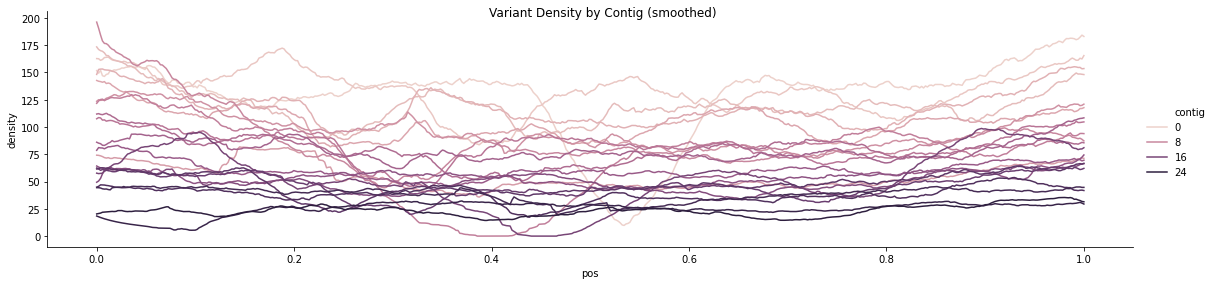

In [5]:
def density(g):
    hist, bin_edges = np.histogram(g['pos'], bins=512)
    p = bin_edges[:-1]
    return pd.DataFrame({
        'pos': (p - p.min()) / (p.max() - p.min()),
        'density': pd.Series(hist).rolling(50, center=True, min_periods=1).mean().values
    })
df = (
    ds[['contig', 'pos']]
    .to_dataframe()
    .groupby('contig').apply(density)
    .reset_index()
)
g = sns.relplot(
    data=df, x='pos', y='density', hue='contig', 
    height=4, aspect=4, kind='line'
)
g.fig.suptitle('Variant Density by Contig (smoothed)')

In [6]:
mvd = df.pipe(lambda df: df[df['pos'] < .01]).groupby('contig')['density'].mean().sort_values()[::-1]
target_contig = mvd.index[0]
mvd

contig
8     183.788177
3     169.514125
2     162.600617
4     151.953820
1     149.051602
5     141.429202
7     124.806281
9     124.240690
11    111.902734
10    107.094662
12     84.381577
13     80.386891
6      73.006575
14     62.489039
18     62.284082
17     60.907159
16     58.285974
15     55.439798
19     46.268893
20     43.735500
22     21.350844
21     16.792220
Name: density, dtype: float64

Subset to the chosen chromosome (8 @ TOW):

In [7]:
dss = ds.sel(variant=ds.contig == target_contig)
# Rechunk to something smaller or at least close to target chunk size
# (otherwise zarr has to load blocks into memory that are too large)
dss = dss.chunk({'variant': 1000, 'sample': -1})
dss

<xarray.Dataset>
Dimensions:  (sample: 629, variant: 44873)
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 7 ... 621 622 623 624 625 626 627 628
  * variant  (variant) int64 2744266 2744272 2744273 ... 3065288 3065298 3065304
Data variables:
    data     (variant, sample) int8 dask.array<chunksize=(1000, 629), meta=np.ndarray>
    contig   (variant) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    pos      (variant) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

Show variant density distribution within 1000kbp windows, the target LD prune parameterization:

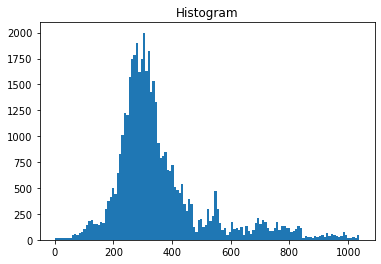

In [8]:
intervals = api.axis_intervals(dss, window=1_000_000, unit='physical', backend='numba')
window_sizes = intervals[0].sel(var='count')
average_window_size = window_sizes.mean().item(0)
window_sizes.plot.hist(bins=128);

Repeat data for the samples however many times are required to hit ~489k samples (this will leave R2 calculation unchanged):

In [9]:
repeats = (target_shape[1] // dss.dims['sample']) + 1
repeats

778

In [10]:
dsc = (
    xr.concat([dss]*repeats, dim='sample', data_vars='different')
    .drop(['variant', 'sample'])
    .assign_coords(
        variant=lambda ds: np.arange(ds.dims['variant']),
        sample=lambda ds: np.arange(ds.dims['sample'])
    )
    .isel(sample=slice(0, target_shape[1]))
)
dsc

<xarray.Dataset>
Dimensions:  (sample: 489212, variant: 44873)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 ... 44867 44868 44869 44870 44871 44872
  * sample   (sample) int64 0 1 2 3 4 5 ... 489207 489208 489209 489210 489211
Data variables:
    contig   (variant) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    pos      (variant) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    data     (variant, sample) int8 dask.array<chunksize=(1000, 629), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

Write the dataset out to disk as that is how it will be delivered:

In [11]:
api.write_zarr(dsc, '/tmp/ukbb_ds.zarr', rechunk=True, mode='w')

In [15]:
!du -sh /tmp/ukbb_ds.zarr

4.3G	/tmp/ukbb_ds.zarr


In [16]:
dsbm = xr.open_zarr('/tmp/ukbb_ds.zarr')
dsbm

<xarray.Dataset>
Dimensions:  (sample: 489212, variant: 44873)
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 ... 489207 489208 489209 489210 489211
  * variant  (variant) int64 0 1 2 3 4 5 ... 44867 44868 44869 44870 44871 44872
Data variables:
    contig   (variant) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    data     (variant, sample) int8 dask.array<chunksize=(1000, 629), meta=np.ndarray>
    pos      (variant) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

Time LD prune for smaller variant subset:

In [17]:
target_chunk_size = int(average_window_size) * 4
target_chunk_size

1440

In [18]:
%%time
api.ld_prune(
    dsbm, 
    threshold=0.2, 
    window=1_000_000, 
    unit='physical', 
    target_chunk_size=target_chunk_size, 
    backend='dask/numba'
).count().compute(scheduler='threads', num_workers=16, threads_per_worker=1)

CPU times: user 14h 53min 24s, sys: 53.4 s, total: 14h 54min 18s
Wall time: 1h 6min 19s


<xarray.Dataset>
Dimensions:        ()
Data variables:
    index_to_drop  int64 35403